In [1]:
!pip install tsaug

You should consider upgrading via the 'C:\Users\medei\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
from tsai.all import *

my_setup()

C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.0+cu116
device          : 1 gpu (['NVIDIA GeForce RTX 2070 with Max-Q Design'])
cpu cores       : 6
threads per cpu : 2
RAM             : 15.84 GB
GPU memory      : [8.0] GB


In [3]:
import scripts.preprocessing as prep
import scripts.experiment_funcs as exp
import scripts.data_aug_funcs as da

import numpy as np
import tsaug
from sklearn.model_selection import KFold

In [4]:
time_series, hemoglobin = prep.create_dataset('../data', 'Hemoglobina.csv')

In [5]:
def find_medoid_sequence(X, step=5):
    mins = []

    for k in range(0, X.shape[0], step):
        min_sum = np.inf
        
        for i in range(k,k+step):
            this_sum = 0

            for j in range(k,k+step):
                this_sum += np.sum(np.square(X[i] - X[j]))

            if (this_sum < min_sum):
                this_sum = min_sum
                min_idx = i

    mins.append(min_idx)

    return mins

# Only windowing





Execution #0


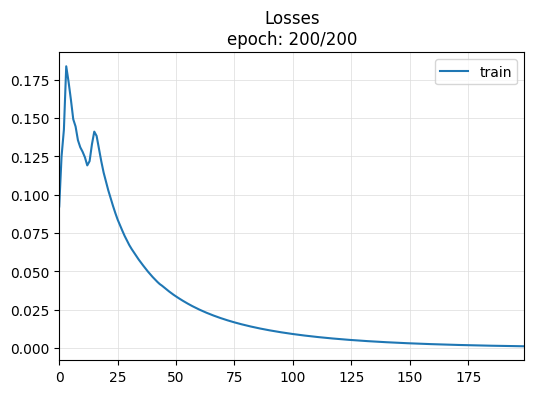

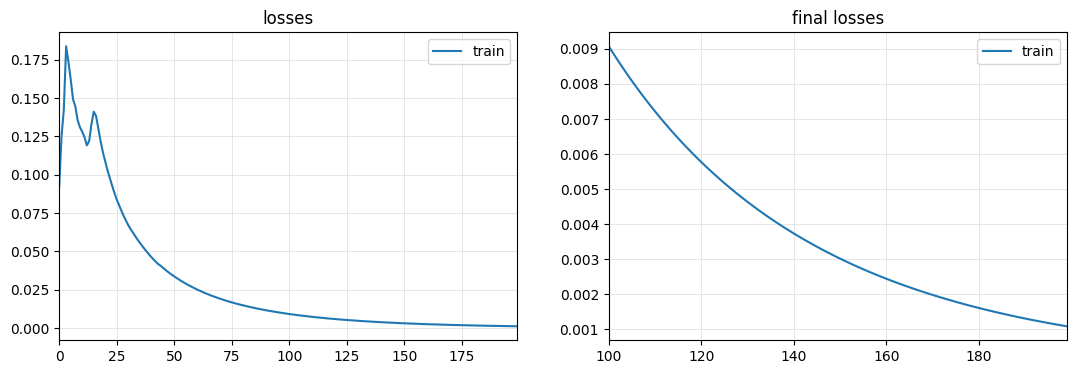

torch.Size([1, 1])
(11,)
(1, 1)


ValueError: cannot reshape array of size 1 into shape (11,)

In [11]:
preds_win = np.zeros([time_series.shape[0], 5], dtype=float)

for i in range(5):

    print('\n\n\nExecution #'+str(i))

    kf = KFold(n_splits=10)

    for train, test in kf.split(time_series):

        X_train, X_test, y_train, y_test = (time_series[train], 
                                            time_series[test], 
                                            hemoglobin[train], 
                                            hemoglobin[test])

        X_train_aug, y_train_aug = da.windowing(X_train, y_train, 5)

        medoids = find_medoid_sequence(X_train_aug)

        X_train_aug = X_train_aug[medoids]
        y_train_aug = y_train_aug[medoids]

        y_train_normalized, norm = prep.normalize_parameters(y_train_aug)

        X_test_aug, y_test_aug = da.windowing(X_test, y_test, 5)

        medoids = find_medoid_sequence(X_test_aug)
        X_test_aug = X_test_aug[medoids]
        y_test_aug = y_test_aug[medoids]

        batch_tfms = TSStandardize(by_sample=True)
        reg = TSRegressor(X_train_aug, y_train_normalized.T[0], 
                          path='models', 
                          arch=ResNet,  # ResNet, InceptionTime, TST, LSTM, RNN_FCN, FCN
                          batch_tfms=batch_tfms, 
                          metrics=rmse,
                          cbs=ShowGraph(), 
                          verbose=False)

        reg.fit_one_cycle(200, 3e-4)
        raw_preds, target, y_pred = reg.get_X_preds(X_test_aug, y_test_aug)
        print(y_pred.shape)

        y_pred = norm.inverse_transform(y_pred)

        print(preds_win[test,i].shape)
        print(y_pred.shape)
        preds_win[test,i] = y_pred.reshape(preds_win[test,i].shape)

In [ ]:
np.savetxt(path + 'preds_win_resnet_limpeza.csv', preds_win,delimiter = ',')

ae_win = np.abs(np.tile(hemoglobin,(5,1)).T-preds_win)
se_win = np.square(np.tile(hemoglobin,(5,1)).T-preds_win)

np.savetxt(path + 'absoluteerrors_win_resnet_limpeza.csv', ae_win,delimiter = ',')
np.savetxt(path + 'squarederrors_win_resnet_limpeza.csv', se_win,delimiter = ',')

In [ ]:
ae_win = np.abs(np.tile(hemoglobin, (5,1)).T - preds_win)
np.mean(ae_win)

# Windowing e augment




Execution #0


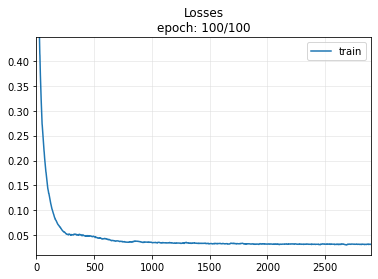

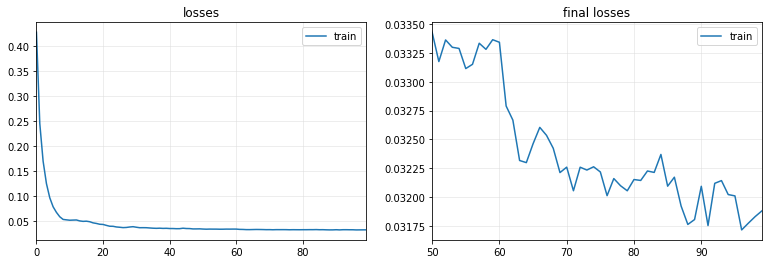

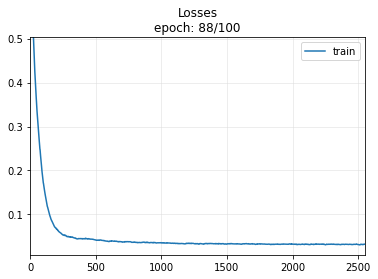

In [ ]:
preds_aug20 = np.zeros([time_series.shape[0],5], dtype=float)

for i in range(5):

  print('\n\n\nExecution #'+str(i))

  kf = KFold(n_splits=10)

  for train, test in kf.split(time_series):

    X_train, X_test, y_train, y_test = (time_series[train], 
                                        time_series[test], 
                                        hemoglobin[train], 
                                        hemoglobin[test])
    
    X_train_aug, y_train_aug = da.windowing(X_train, y_train, 5)

    medoids = find_medoid_sequence(X_train_aug)

    X_train_aug = X_train_aug[medoids]
    y_train_aug = y_train_aug[medoids]

    X_train_aug, y_train_aug = da.time_series_augmentations(
        X_train_aug, y_train_aug, 19,
        [tsaug.TimeWarp(), tsaug.AddNoise(), tsaug.Drift()])

    y_train_normalized, norm = prep.normalize_parameters(y_train_aug)

    X_test_aug, y_test_aug = da.windowing(X_test, y_test, 5)

    medoids = find_medoid_sequence(X_test_aug)
    X_test_aug = X_test_aug[medoids]
    y_test_aug = y_test_aug[medoids]

    batch_tfms = TSStandardize(by_sample=True)
    reg = TSRegressor(X_train_aug, y_train_normalized.T[0], 
                      path='models', 
                      arch=ResNet,  # ResNet, InceptionTime, TST, LSTM, RNN_FCN, FCN
                      batch_tfms=batch_tfms, 
                      metrics=rmse,
                      cbs=ShowGraph(), 
                      verbose=False)
    
    reg.fit_one_cycle(100, 3e-4)

    raw_preds, target, y_pred = reg.get_X_preds(X_test_aug, y_test_aug)

    y_pred = norm.inverse_transform(y_pred)

    for k in range(y_test.shape[0]):
        preds_aug20[test[k], i] = np.median(y_pred[k*5:k*5+5])


In [ ]:
np.savetxt(path+'preds_aug20_limpeza_resnet.csv', preds_aug20,delimiter = ',')

ae_aug20 = np.abs(np.tile(hemoglobin,(5,1)).T-preds_aug20)
se_aug20 = np.square(np.tile(hemoglobin,(5,1)).T-preds_aug20)
np.savetxt(path+'absoluteerrors_aug20_limpeza_resnet.csv', ae_aug20,delimiter = ',')
np.savetxt(path+'squarederrors_aug20_limpeza_resnet.csv', se_aug20,delimiter = ',')

In [ ]:
ae_aug20 = np.loadtxt(path+'absoluteerrors_aug20_limpeza_resnet.csv', delimiter = ',')
se_aug20 = np.loadtxt(path+'squarederrors_aug20_limpeza_resnet.csv', delimiter = ',')

In [ ]:
np.mean(ae_aug20)

Tentando 3 subseqs

In [ ]:
def find_triple(X,step=5):

  mins = np.zeros([int(3*X.shape[0]/step)], dtype=int)

  for k in range(0,X.shape[0],step): #cada quintupla

    all_sums = []
    for i in range(k,k+step): # cada exemplo da quintupla

      this_sum = 0
      for j in range(k,k+step): # cada par do exemplo (até ele mesmo tá aqui)
        this_sum += np.sum(np.square(X[i]-X[j]))
    
      all_sums.append(this_sum)

    min_idx = np.argsort(all_sums)

    # print(min_idx)
    start_idx = int(k/5)
    mins[start_idx*3:start_idx*3+3] = min_idx[:3]+k

  return mins

In [ ]:
t = find_triple(time_series[:15])

In [ ]:
time_series[t].shape

(9, 900, 3)




Execution #0


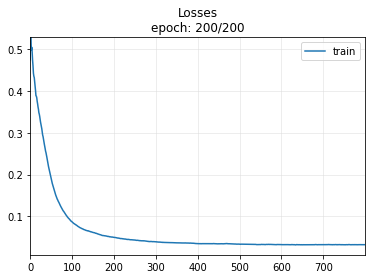

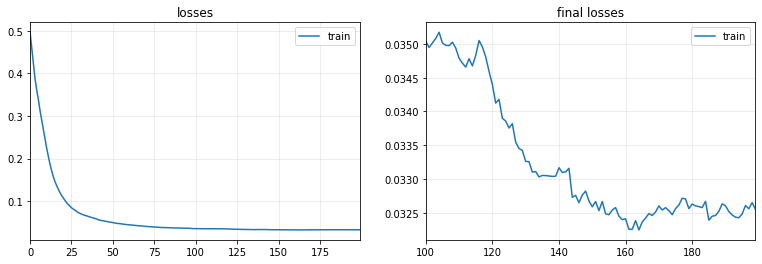

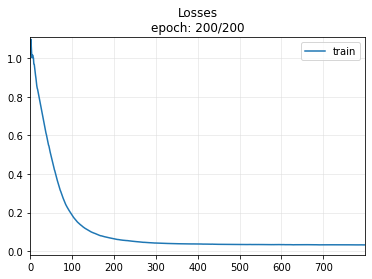

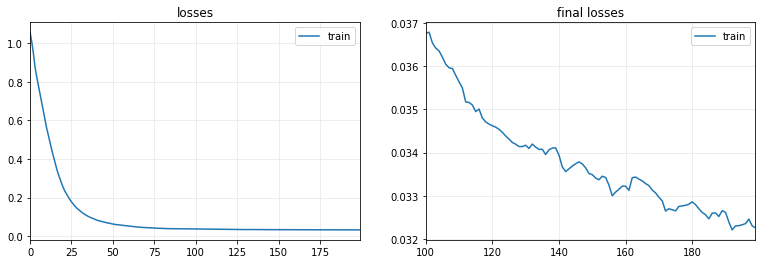

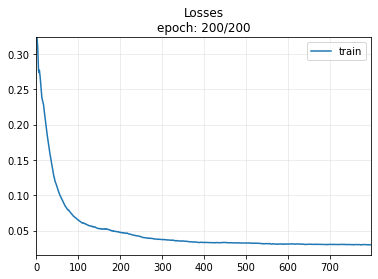

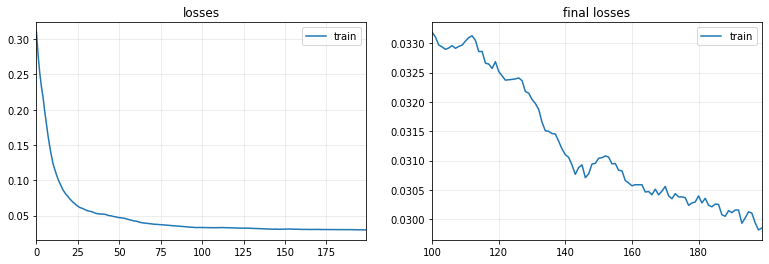

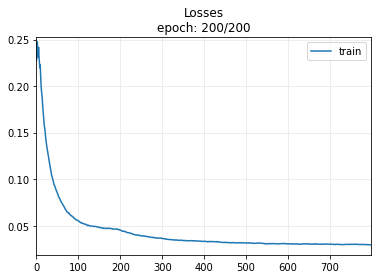

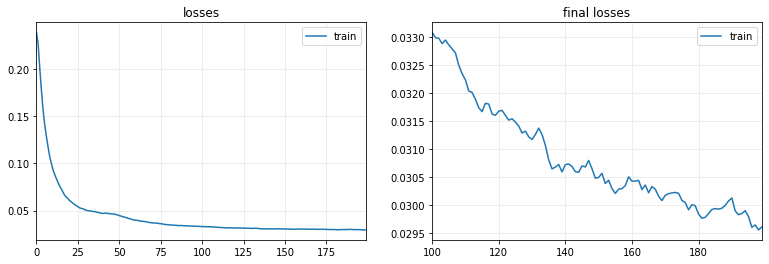

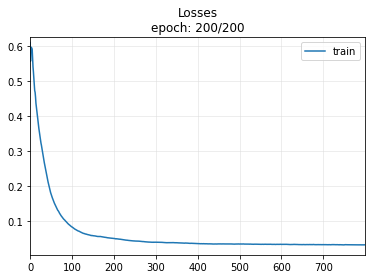

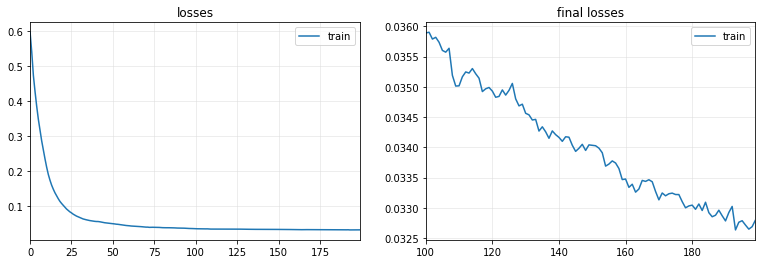

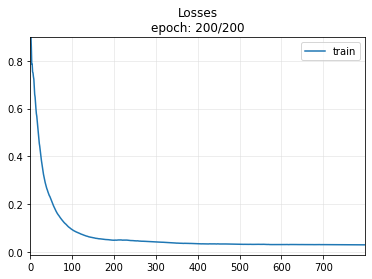

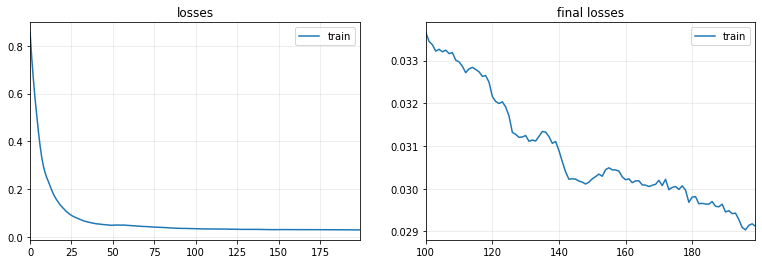

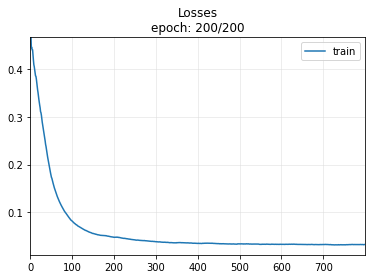

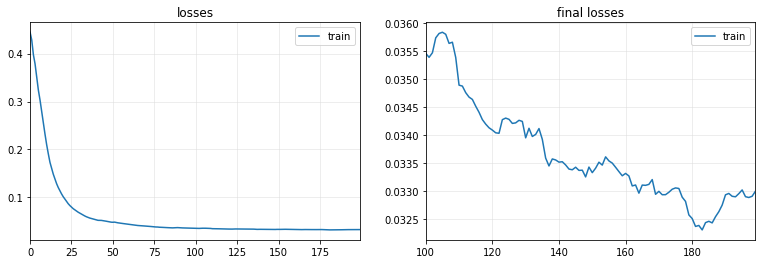

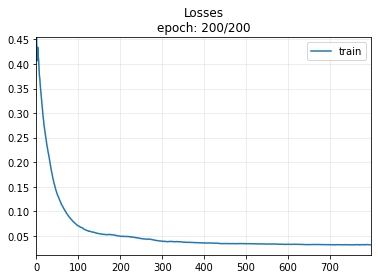

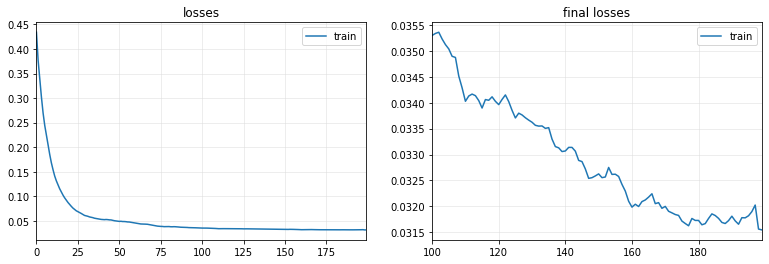

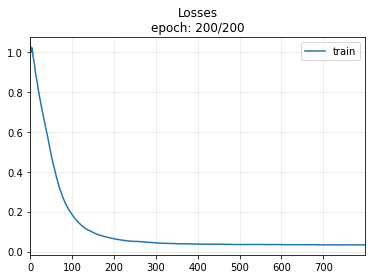

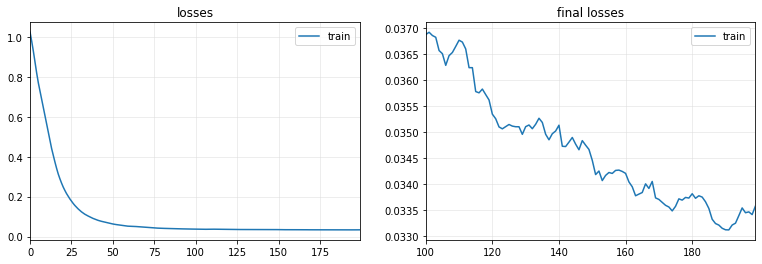

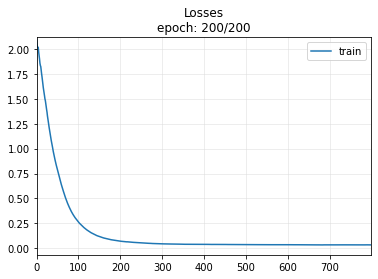

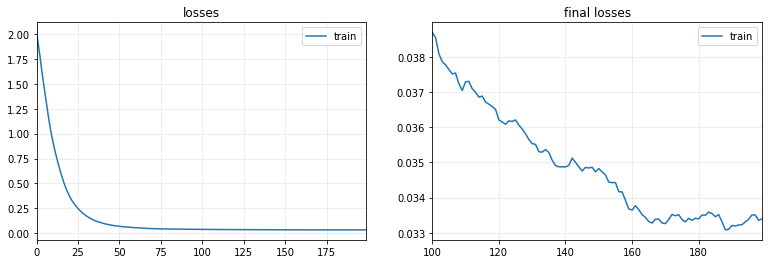

In [ ]:
preds_win = np.zeros([time_series.shape[0],5], dtype=float)

for i in range(5):

  print('\n\n\nExecution #'+str(i))

  kf = KFold(n_splits=10)

  for train, test in kf.split(time_series):

    X_train, X_test, y_train, y_test = (time_series[train], 
                                        time_series[test], 
                                        hemoglobin[train], 
                                        hemoglobin[test])
    
    X_train_aug, y_train_aug = da.windowing(X_train, y_train, 5)

    medoids = find_triple(X_train_aug)

    X_train_aug = X_train_aug[medoids]
    y_train_aug = y_train_aug[medoids]

    y_train_normalized, norm = prep.normalize_parameters(y_train_aug)

    X_test_aug, y_test_aug = da.windowing(X_test, y_test, 5)

    medoids = find_medoid_sequence(X_test_aug)
    X_test_aug = X_test_aug[medoids]
    y_test_aug = y_test_aug[medoids]

    batch_tfms = TSStandardize(by_sample=True)
    reg = TSRegressor(X_train_aug, y_train_normalized.T[0], 
                      path='models', 
                      arch=ResNet,  # ResNet, InceptionTime, TST, LSTM, RNN_FCN, FCN
                      batch_tfms=batch_tfms, 
                      metrics=rmse,
                      cbs=ShowGraph(), 
                      verbose=False)
    
    reg.fit_one_cycle(200, 3e-4)
    raw_preds, target, y_pred = reg.get_X_preds(X_test_aug, y_test_aug)

    y_pred = norm.inverse_transform(y_pred)
    
    preds_win[test,i] = y_pred.reshape(preds_win[test,i].shape)


In [ ]:
ae = np.abs(hemoglobin-preds_win[:,0])
np.average(ae)

1.5831387703429978

In [ ]:
np.savetxt(path+'preds_win_resnet_limpeza_tripla.csv', preds_win,delimiter = ',')

ae_win = np.abs(np.tile(hemoglobin,(5,1)).T-preds_win)
se_win = np.square(np.tile(hemoglobin,(5,1)).T-preds_win)
np.savetxt(path+'absoluteerrors_win_resnet_limpeza_tripla.csv', ae_win,delimiter = ',')
np.savetxt(path+'squarederrors_win_resnet_limpeza_tripla.csv', se_win,delimiter = ',')




Execution #0


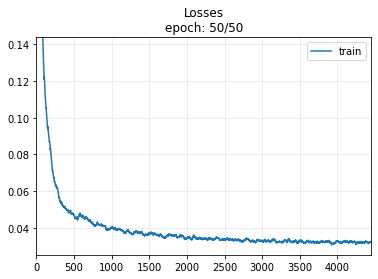

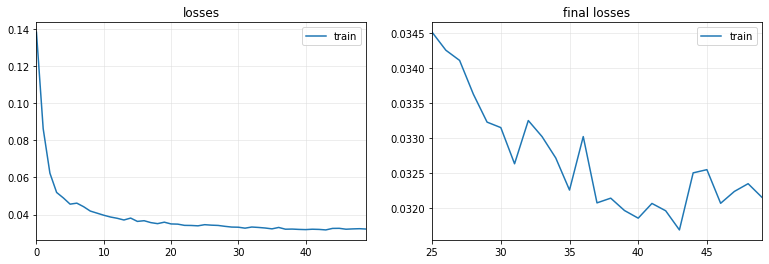

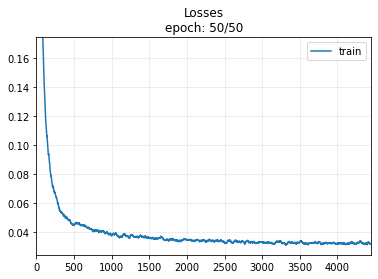

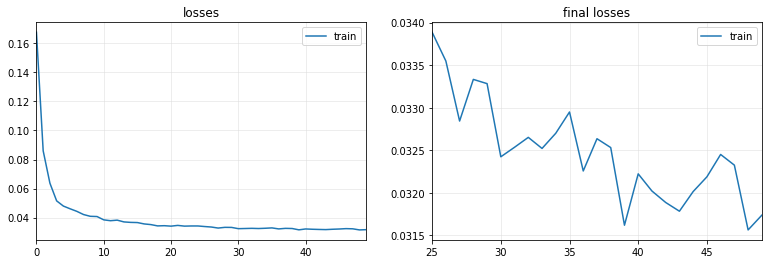

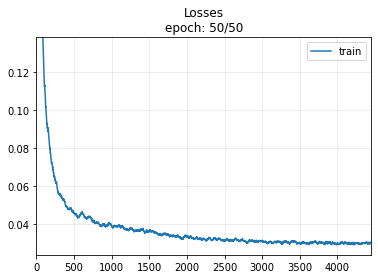

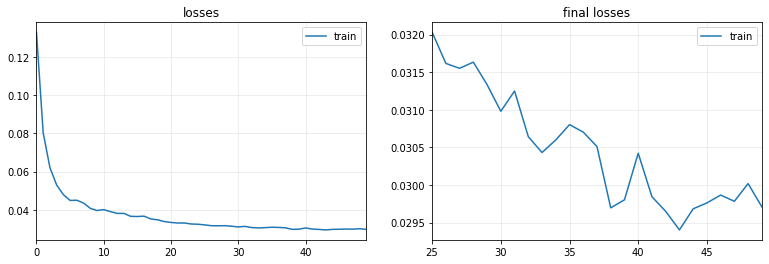

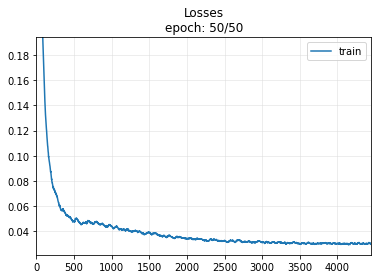

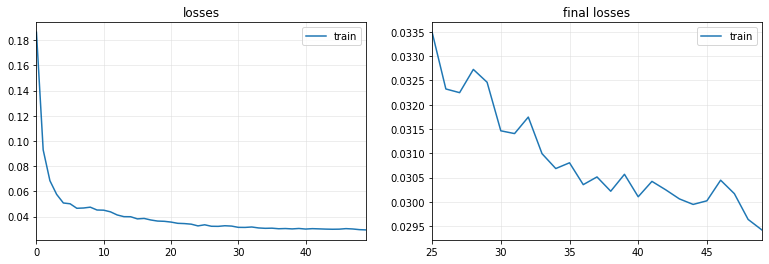

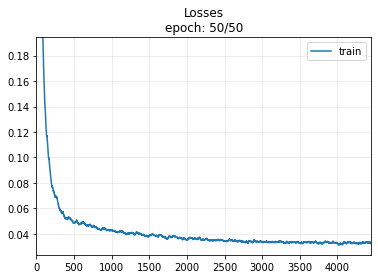

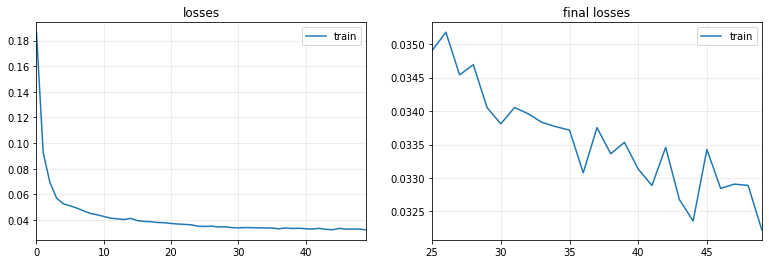

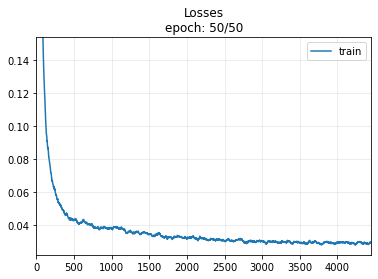

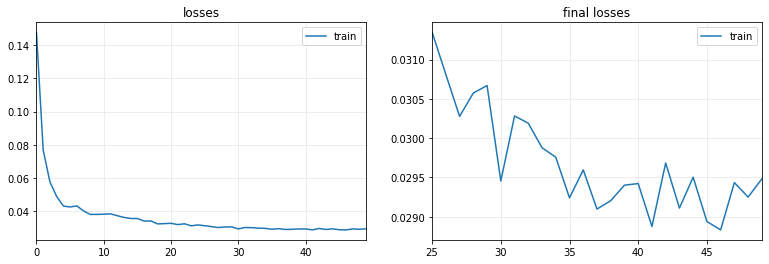

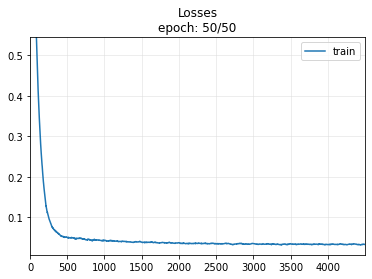

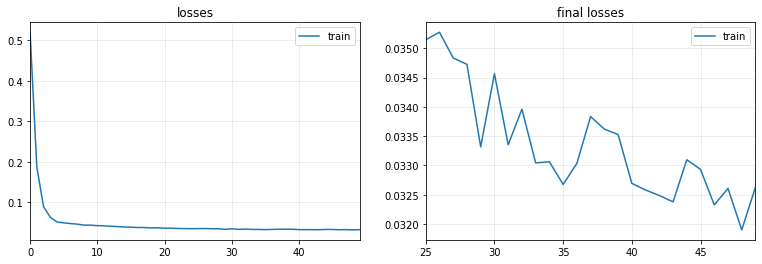

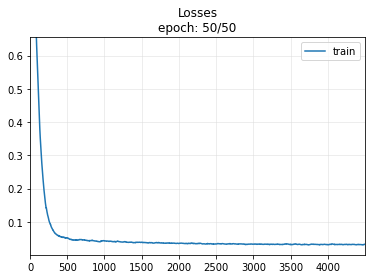

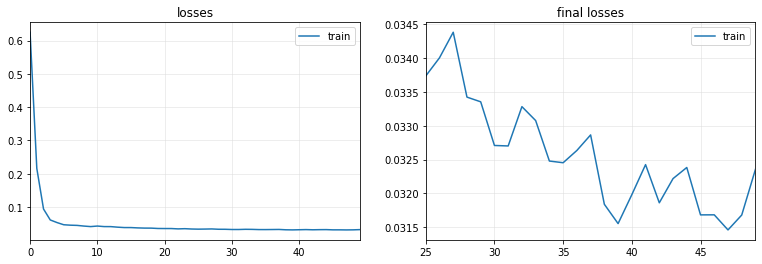

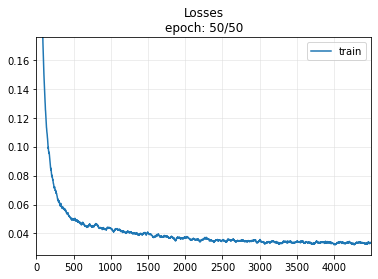

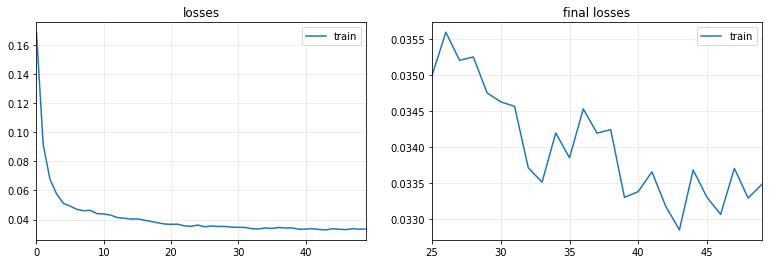

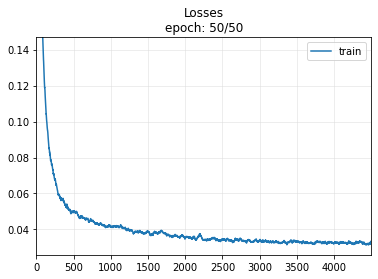

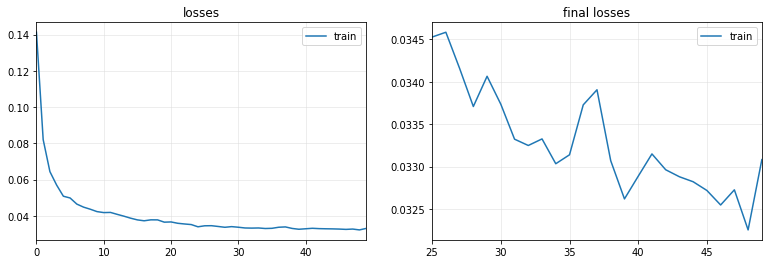




Execution #1


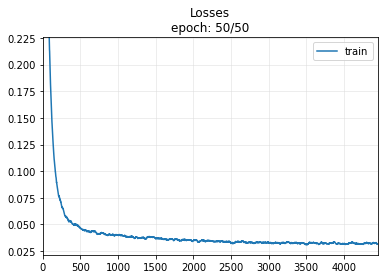

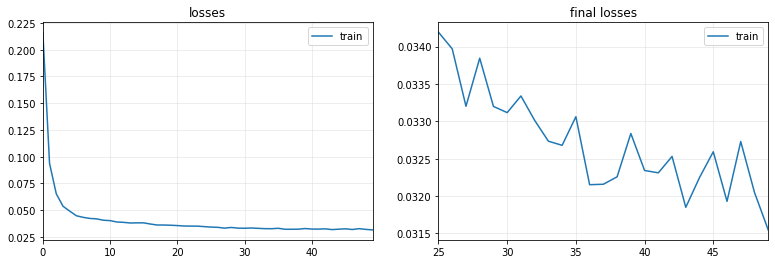

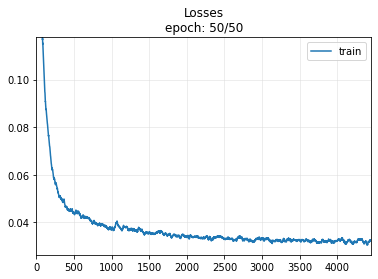

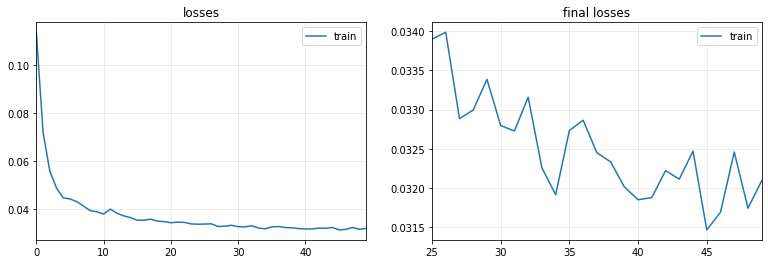

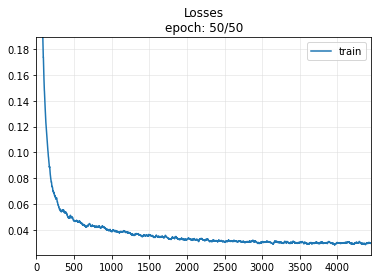

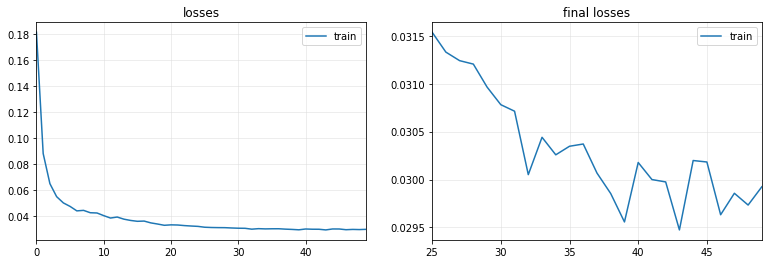

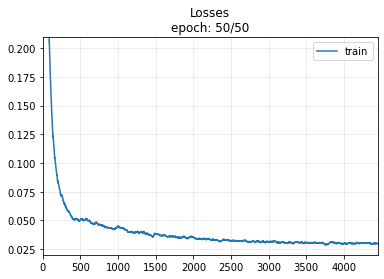

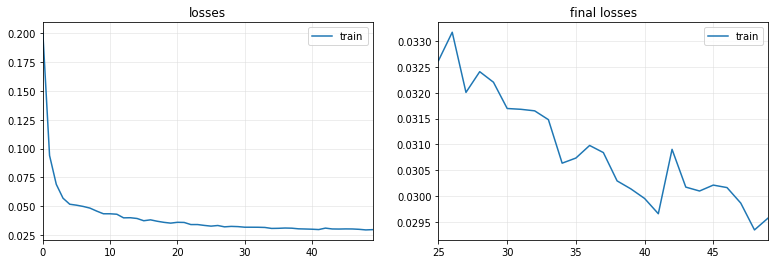

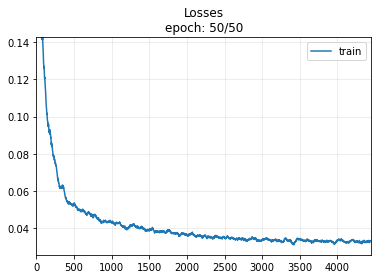

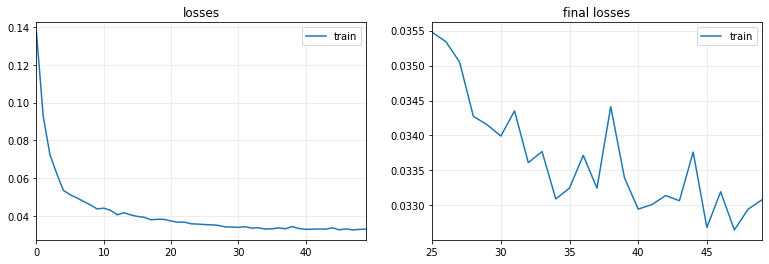

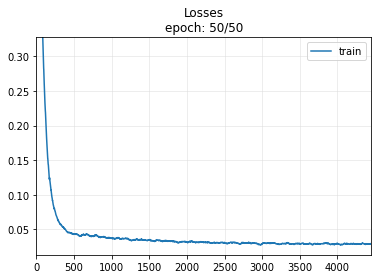

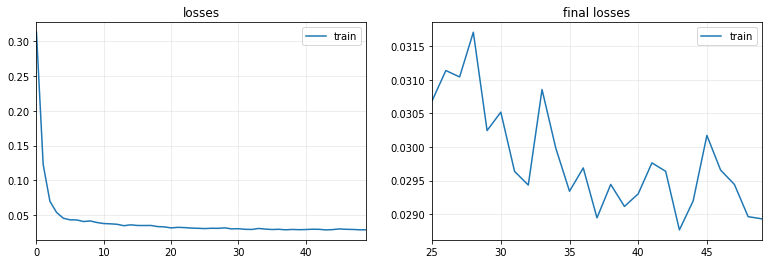

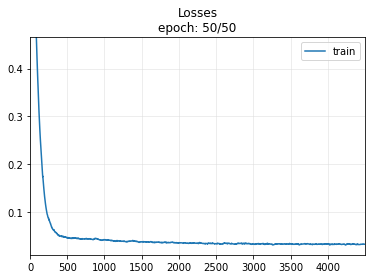

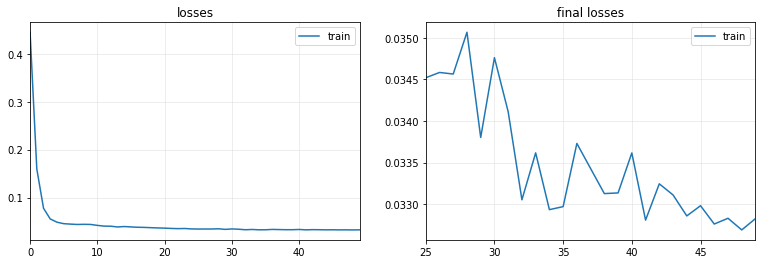

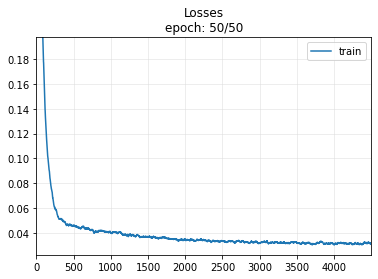

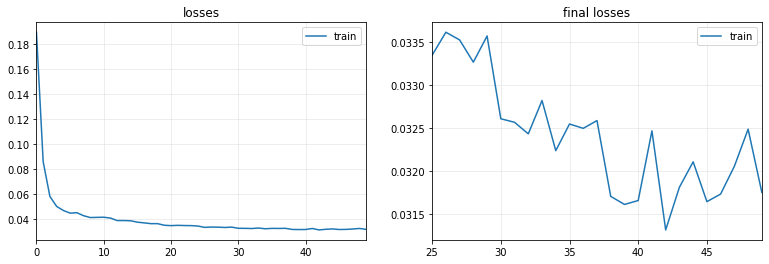

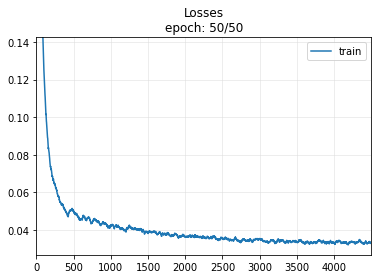

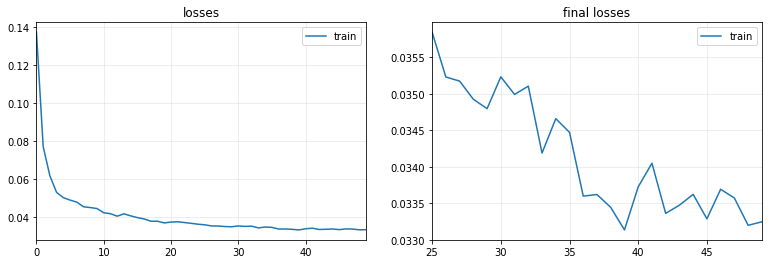

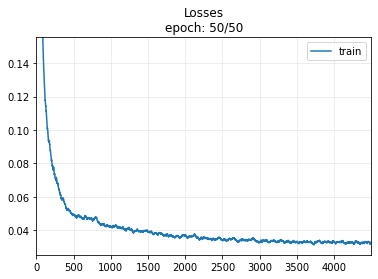

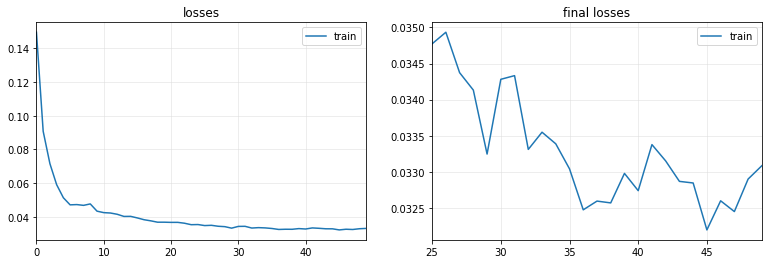




Execution #2


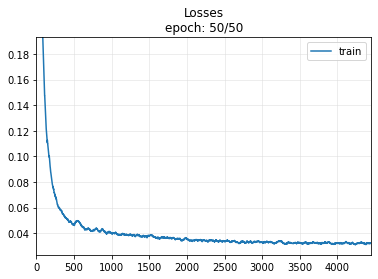

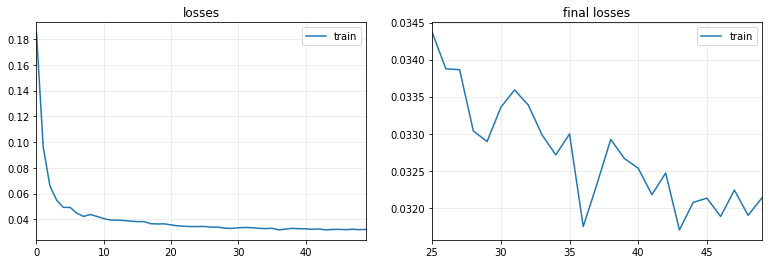

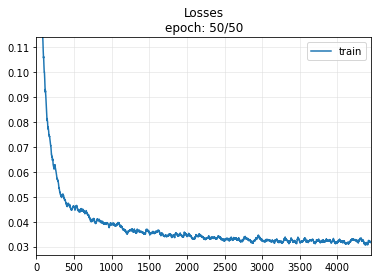

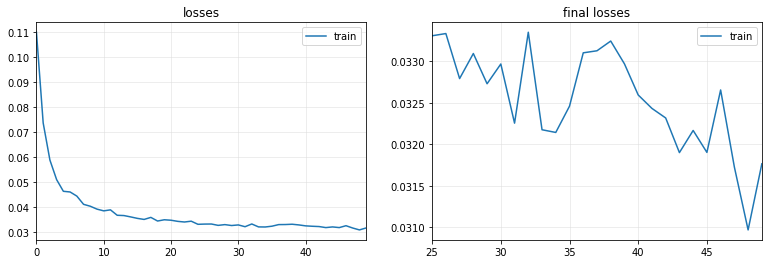

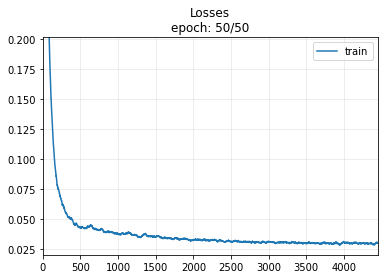

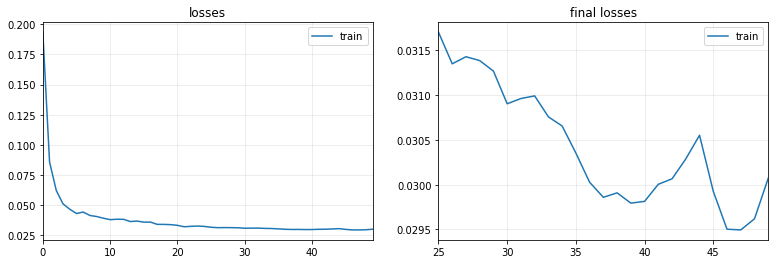

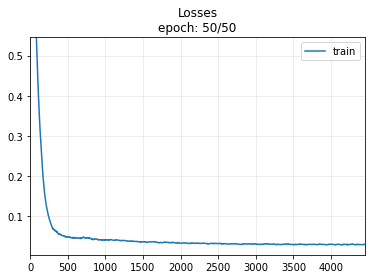

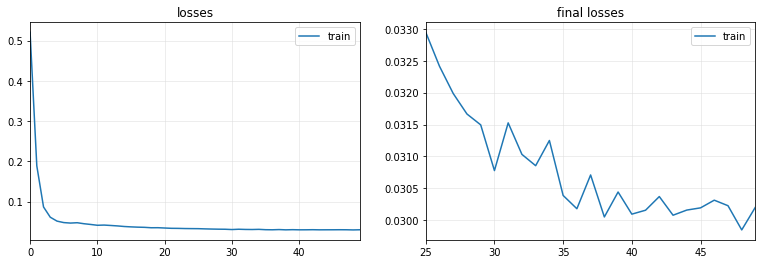

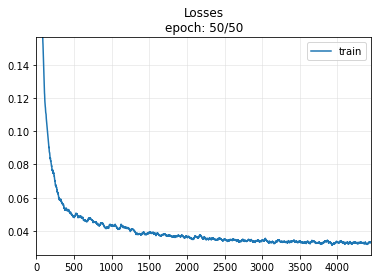

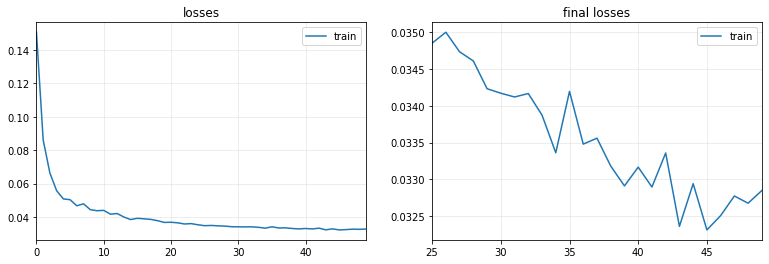

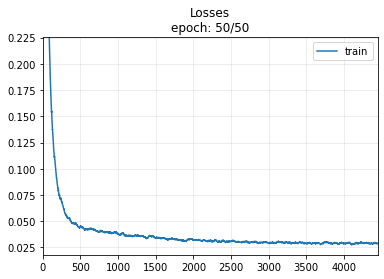

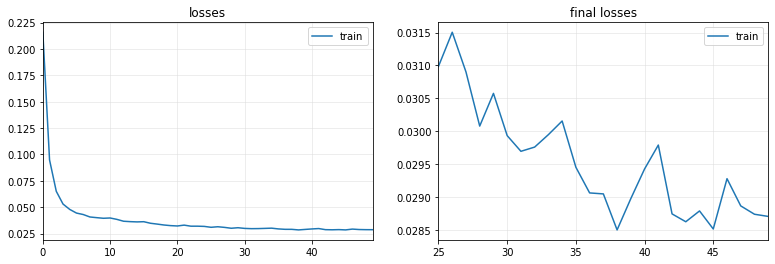

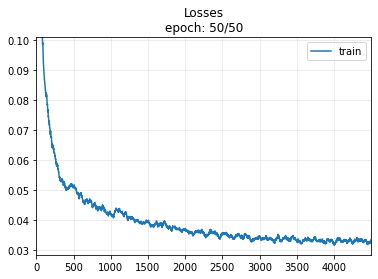

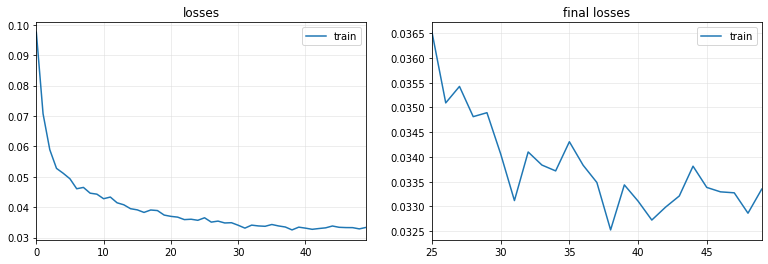

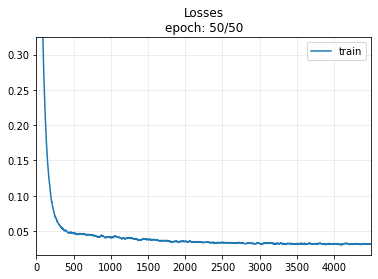

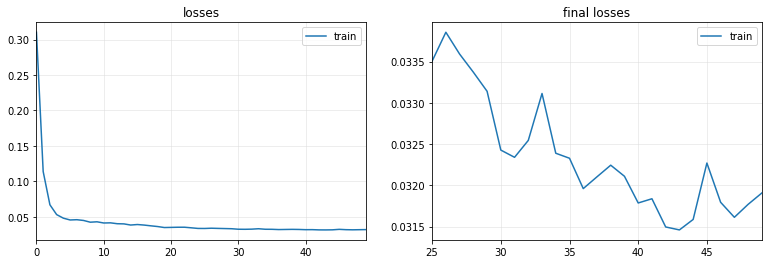

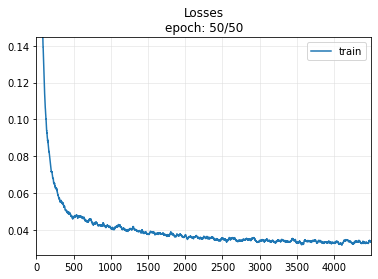

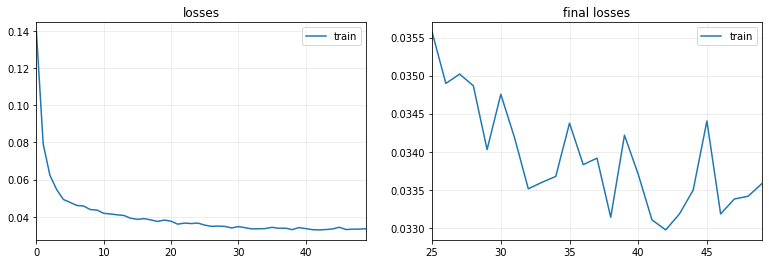

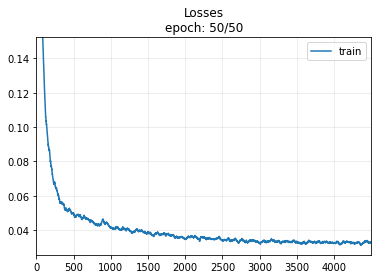

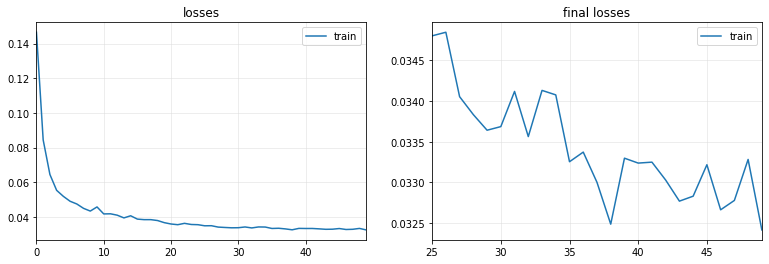




Execution #3


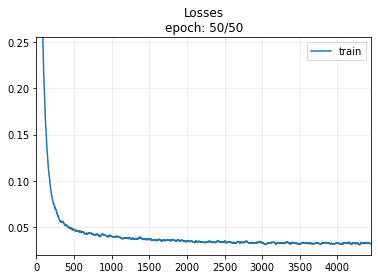

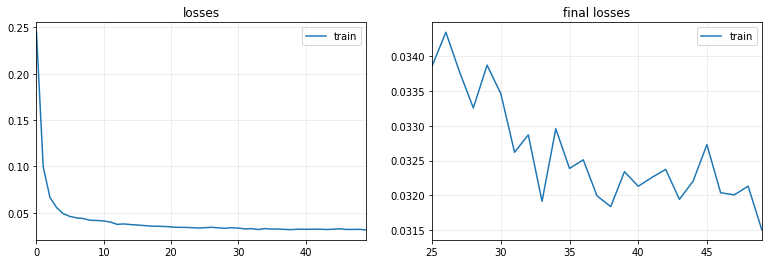

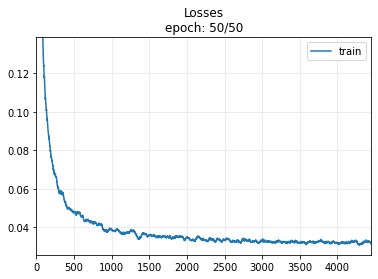

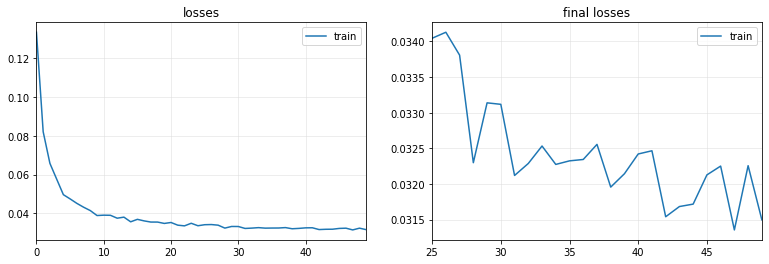

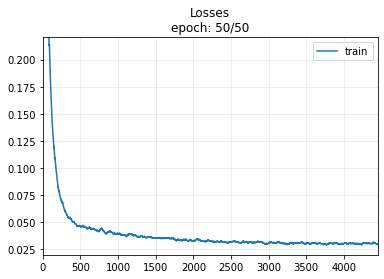

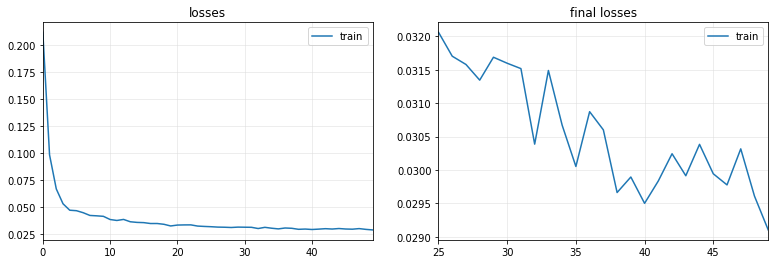

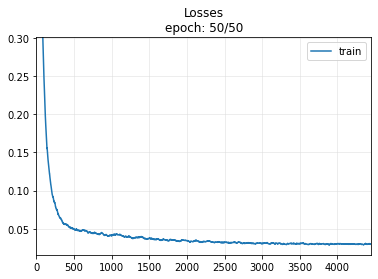

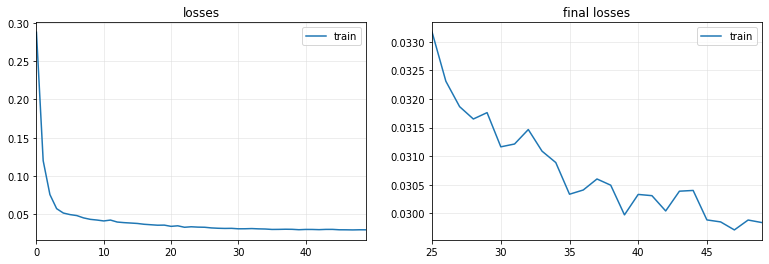

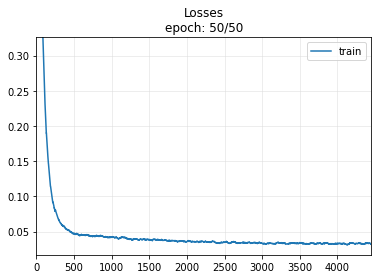

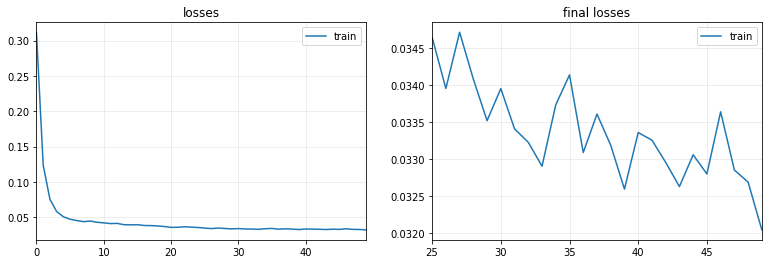

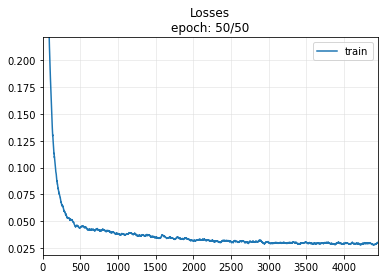

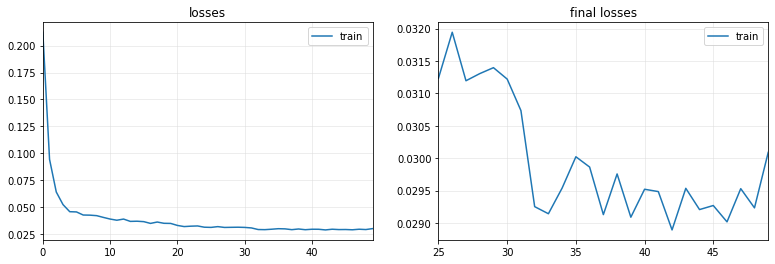

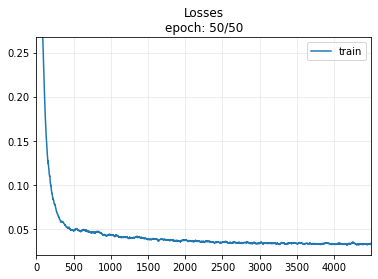

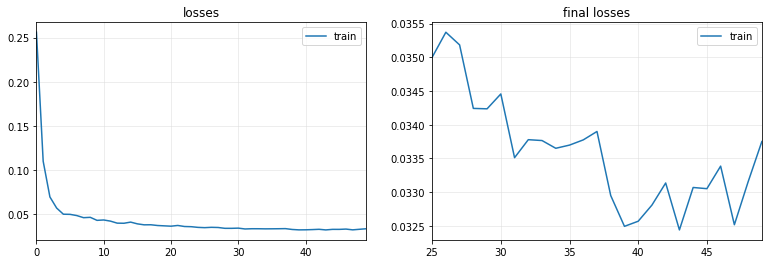

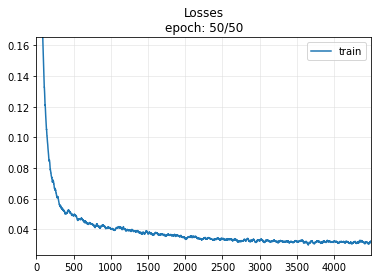

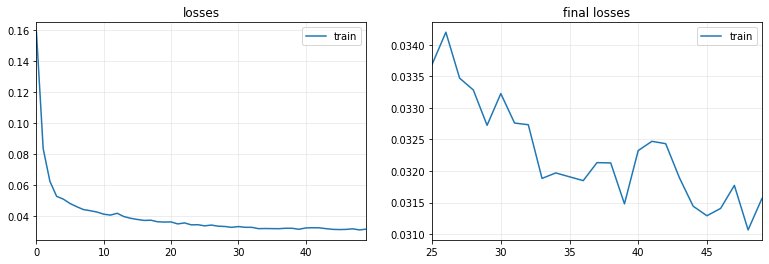

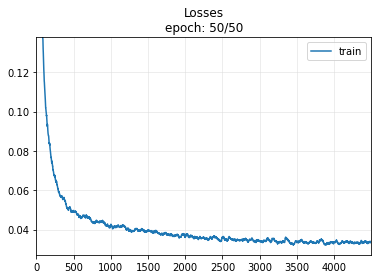

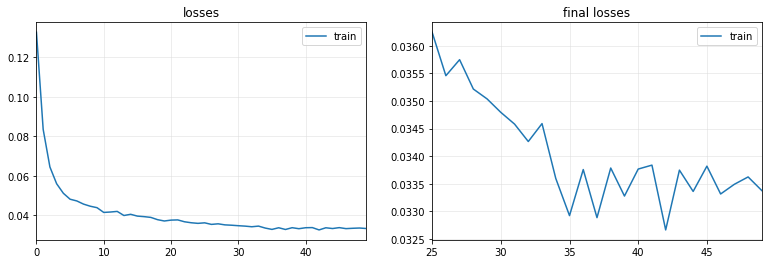

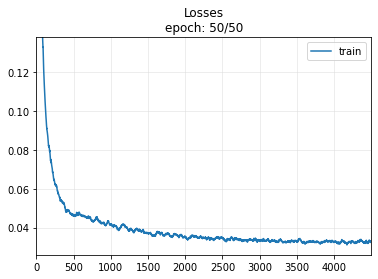

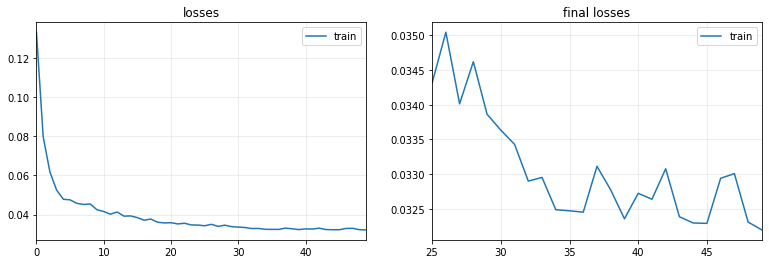




Execution #4


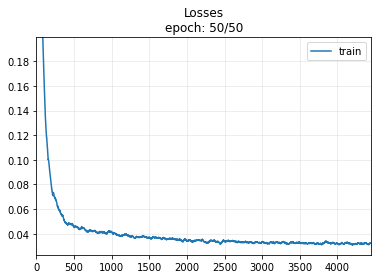

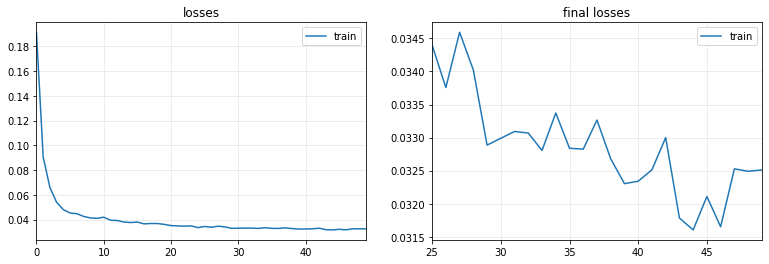

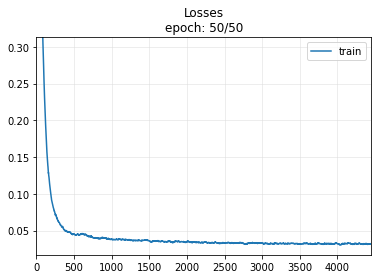

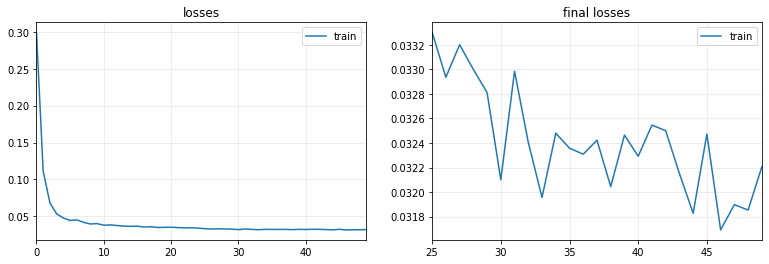

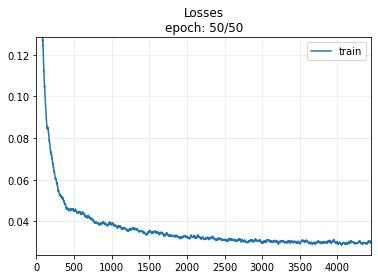

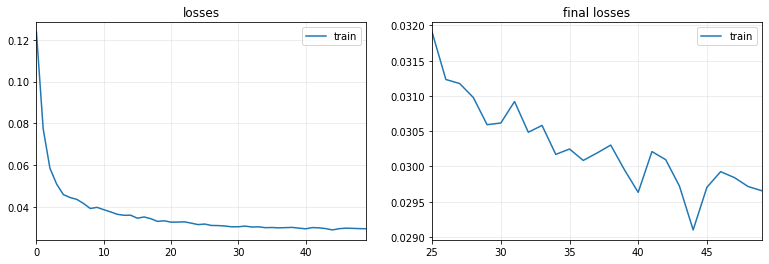

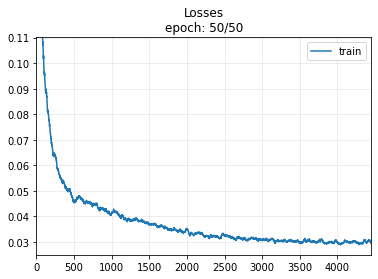

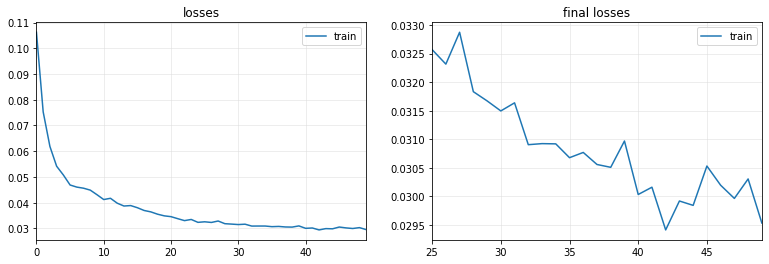

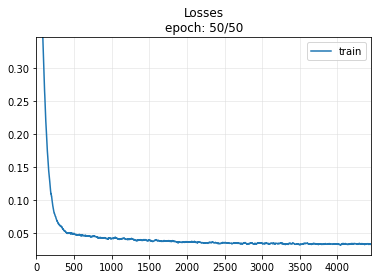

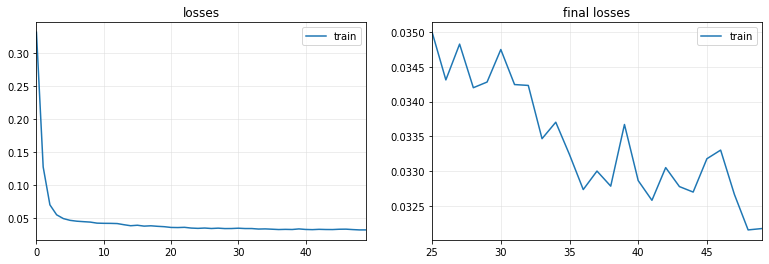

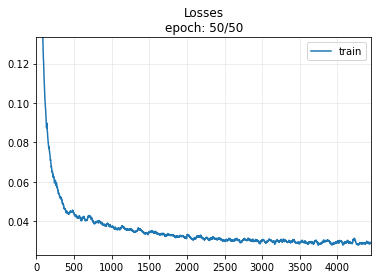

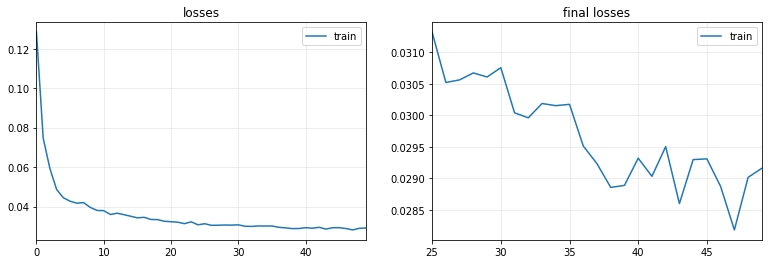

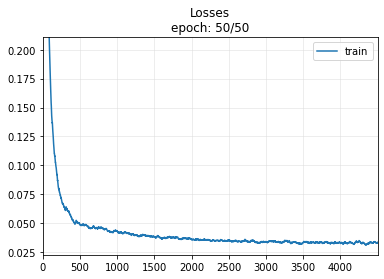

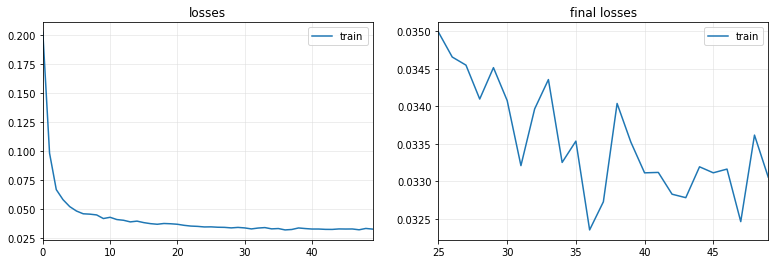

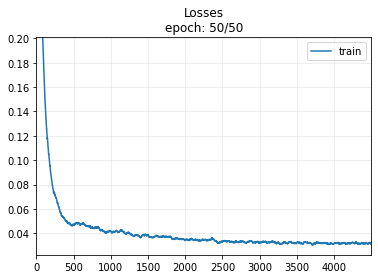

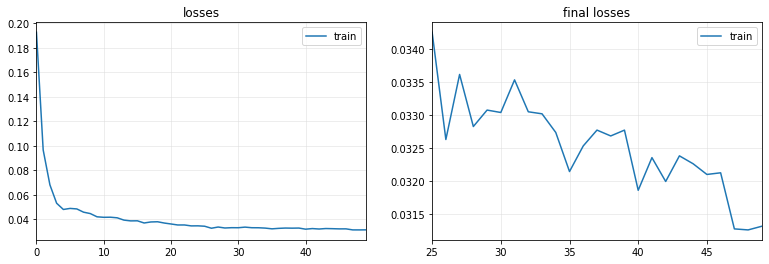

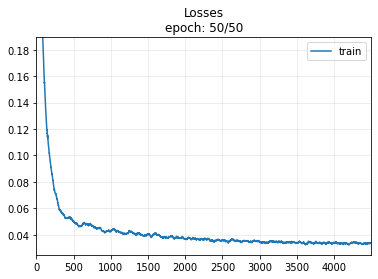

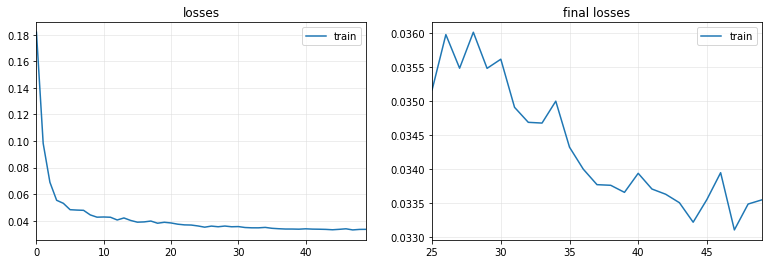

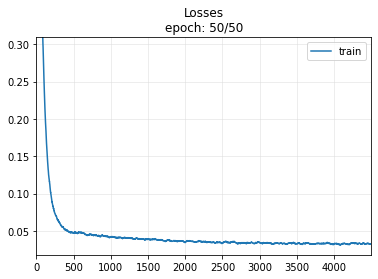

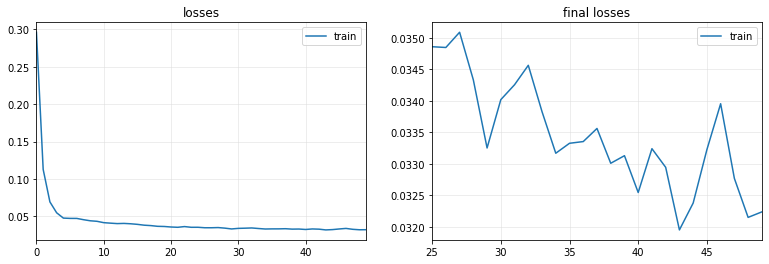

In [ ]:
preds_aug20 = np.zeros([time_series.shape[0],5], dtype=float)

for i in range(5):

  print('\n\n\nExecution #'+str(i))

  kf = KFold(n_splits=10)

  for train, test in kf.split(time_series):

    X_train, X_test, y_train, y_test = (time_series[train], 
                                        time_series[test], 
                                        hemoglobin[train], 
                                        hemoglobin[test])
    
    X_train_aug, y_train_aug = da.windowing(X_train, y_train, 5)

    medoids = find_triple(X_train_aug)

    X_train_aug = X_train_aug[medoids]
    y_train_aug = y_train_aug[medoids]

    X_train_aug, y_train_aug = da.time_series_augmentations(
        X_train_aug, y_train_aug, 19,
        [tsaug.TimeWarp(), tsaug.AddNoise(), tsaug.Drift()])

    y_train_normalized, norm = prep.normalize_parameters(y_train_aug)

    X_test_aug, y_test_aug = da.windowing(X_test, y_test, 5)

    medoids = find_medoid_sequence(X_test_aug)
    X_test_aug = X_test_aug[medoids]
    y_test_aug = y_test_aug[medoids]

    batch_tfms = TSStandardize(by_sample=True)
    reg = TSRegressor(X_train_aug, y_train_normalized.T[0], 
                      path='models', 
                      arch=ResNet,  # ResNet, InceptionTime, TST, LSTM, RNN_FCN, FCN
                      batch_tfms=batch_tfms, 
                      metrics=rmse,
                      cbs=ShowGraph(), 
                      verbose=False)
    
    reg.fit_one_cycle(50, 3e-4)

    raw_preds, target, y_pred = reg.get_X_preds(X_test_aug, y_test_aug)

    y_pred = norm.inverse_transform(y_pred)

    for k in range(y_test.shape[0]):
        preds_aug20[test[k], i] = np.median(y_pred[k*5:k*5+5])


In [ ]:
np.savetxt(path+'preds_aug20_limpeza_tripla_resnet.csv', preds_aug20,delimiter = ',')

ae_aug20 = np.abs(np.tile(hemoglobin,(5,1)).T-preds_aug20)
se_aug20 = np.square(np.tile(hemoglobin,(5,1)).T-preds_aug20)
np.savetxt(path+'absoluteerrors_aug20_limpeza_tripla_resnet.csv', ae_aug20,delimiter = ',')
np.savetxt(path+'squarederrors_aug20_limpeza_tripla_resnet.csv', se_aug20,delimiter = ',')